In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import make_pipeline

# Load the dataset using pandas
df = pd.read_csv("dataset.csv")
df_original = df.copy(deep=True)

### Data Curation and Preparation

In [21]:
# Analyse the current data (select as appropriate)
# df.describe()
# df.info()
# df.head()
# for col in df.columns:
#     num_unique = df[col].nunique()
#     print(str(col) + ": " + str(num_unique))
df

,sex,age,address,family_size,parents_cohabitation,mothers_education,fathers_education,mothers_job,fathers_job,guardian,...,family_relations,freetime,going_out,alcohol_workday,alcohol_weekend,health,absences,grade_term1,grade_term2,grade_final
0,F,18,U,GT3,A,4,4,at_home,teacher,mother,...,4,3,4,1,1,3,6,5,6,6
1,F,17,U,GT3,T,1,1,at_home,other,father,...,5,3,3,1,1,3,4,5,5,6
2,F,15,U,LE3,T,1,1,at_home,other,mother,...,4,3,2,2,3,3,10,7,8,10
3,F,15,U,GT3,T,4,2,health,services,mother,...,3,2,2,1,1,5,2,15,14,15
4,F,16,U,GT3,T,3,3,other,other,father,...,4,3,2,1,2,5,4,6,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,F,16,U,GT3,T,3,3,other,services,mother,...,4,3,3,2,4,5,54,11,12,11
422,M,15,U,GT3,T,4,3,teacher,other,mother,...,4,3,3,2,3,5,6,9,9,10
423,M,15,U,GT3,T,4,0,teacher,other,mother,...,3,4,3,1,1,1,8,11,11,10
424,F,16,U,GT3,T,2,2,other,other,mother,...,5,2,3,1,3,3,0,11,11,11


In [22]:
# Clean the df 
# Remove rows with null values
df = df.dropna(how="all")
# Remove duplicated rows
df.drop_duplicates()

# Clean the necessary categorical data columns
# Sex is M or F
df = df[df["sex"].isin(["M", "F"])]
# Address is only U or R
df = df[df["address"].isin(["U", "R"])]
# Family size is only GT3 or LE3
df = df[df["family_size"].isin(["GT3", "LE3"])]

# Clean and remove outliers for necessary numerical data columns
# Grades including numbers only
grade_cols = ["grade_term1", "grade_term2", "grade_final"]
df[grade_cols] = df[grade_cols].apply(pd.to_numeric, errors="coerce")
# Grades between values 0 and 20
for col in grade_cols:
    df = df[(df[col] >= 0) & (df[col] <= 20)]
# Use the 1.5*IQR to calculate outliers for independent variables
def outlier_removal(df_outlier, col_outlier):
    IQR_age = df_outlier[col_outlier].quantile(0.75) - df_outlier[col_outlier].quantile(0.25)
    lower_bound = df_outlier[col_outlier].quantile(0.25) - (1.5 * IQR_age)
    upper_bound = df_outlier[col_outlier].quantile(0.75) + (1.5 * IQR_age)
    df_removed = df_outlier[(df_outlier[col_outlier] >= lower_bound) & (df_outlier[col_outlier] <= upper_bound)]
    return df_removed
# Age is not too old
df = outlier_removal(df, "age")
# Number of absences is not too high (maximum now 20)
df = outlier_removal(df, "absences")

# Bin columns with continuous data where necessary
# Bin the absences column into 0 absences, less than 10 and more than 10
df["absences"] = pd.cut(df["absences"], bins=[-1,0.1,5,11,21], labels=["0", "1-5", "6-10", "11-20"], right=False)

# Reset the index of the df
df.reset_index(drop=True, inplace=True)

df_clean = df.copy(deep=True)
df

,sex,age,address,family_size,parents_cohabitation,mothers_education,fathers_education,mothers_job,fathers_job,guardian,...,family_relations,freetime,going_out,alcohol_workday,alcohol_weekend,health,absences,grade_term1,grade_term2,grade_final
0,F,18,U,GT3,A,4,4,at_home,teacher,mother,...,4,3,4,1,1,3,6-10,5.0,6,6
1,F,17,U,GT3,T,1,1,at_home,other,father,...,5,3,3,1,1,3,1-5,5.0,5,6
2,F,15,U,LE3,T,1,1,at_home,other,mother,...,4,3,2,2,3,3,6-10,7.0,8,10
3,F,15,U,GT3,T,4,2,health,services,mother,...,3,2,2,1,1,5,1-5,15.0,14,15
4,F,16,U,GT3,T,3,3,other,other,father,...,4,3,2,1,2,5,1-5,6.0,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400,F,15,R,GT3,T,1,1,other,other,mother,...,3,3,4,2,4,5,1-5,8.0,6,5
401,M,16,U,GT3,T,3,1,other,other,mother,...,5,3,2,2,2,5,1-5,12.0,12,14
402,M,15,U,GT3,T,4,3,teacher,other,mother,...,4,3,3,2,3,5,6-10,9.0,9,10
403,M,15,U,GT3,T,4,0,teacher,other,mother,...,3,4,3,1,1,1,6-10,11.0,11,10


In [23]:
# Normalise the df
# Normalise the binary categorical columns
# Normalise function for binary columns
def normalise_binary(df_normalise, col_binary, option1, option2):
    df_normalise[col_binary] = df_normalise[col_binary].replace({option1: 0, option2: 1})
    df_normalise[col_binary] = df_normalise[col_binary].astype(int)
# Sex M to 0 and F to 1
normalise_binary(df, "sex", "M", "F")
# Address U to 0, R to 1
normalise_binary(df, "address", "U", "R")
# Family size LE3 to 0, GT3 to 1
normalise_binary(df, "family_size", "LE3", "GT3")
# Parents cohabitation T to 0, A to 1
normalise_binary(df, "parents_cohabitation", "T", "A")
# Activies, internet and romantic relationship no to 0, yes to 1
normalise_binary(df, "activities", "no", "yes")
normalise_binary(df, "internet", "no", "yes")
normalise_binary(df, "romantic_relationship", "no", "yes")

# Normalise the other categorical columns
# The string categorical columns
df = pd.get_dummies(df, columns=["mothers_education", "fathers_education", "traveltime", "studytime", "failures",
                                 "family_relations", "freetime", "going_out", "alcohol_workday", "alcohol_weekend", "health"], dtype="int")
# The numerical categorical columns
df = pd.get_dummies(df, columns=["mothers_job", "fathers_job", "guardian", "absences"], dtype="int")

# Normalise the continuous columns between 0 and 1
# Define the scaler
scaler = MinMaxScaler()
# Scale function
def scale(df_scale, continuous_col):
    # Rescale around 0 first, between -1 and 1
    transform = df_scale[continuous_col].values.reshape(-1, 1)
    # Scale to values between 0 and 1
    df_scale[continuous_col] = scaler.fit_transform(transform)
# Normalise the continuous columns
scale(df, "age")
scale(df, "grade_term1")
scale(df, "grade_term2")
scale(df, "grade_final")

# df.to_csv("/check.csv", index=False)
df

,sex,age,address,family_size,parents_cohabitation,activities,internet,romantic_relationship,grade_term1,grade_term2,...,fathers_job_other,fathers_job_services,fathers_job_teacher,guardian_father,guardian_mother,guardian_other,absences_0,absences_1-5,absences_6-10,absences_11-20
0,1,0.500000,0,1,1,0,0,0,0.1250,0.315789,...,0,0,1,0,1,0,0,0,1,0
1,1,0.333333,0,1,0,0,1,0,0.1250,0.263158,...,1,0,0,1,0,0,0,1,0,0
2,1,0.000000,0,0,0,0,1,0,0.2500,0.421053,...,1,0,0,0,1,0,0,0,1,0
3,1,0.000000,0,1,0,1,1,1,0.7500,0.736842,...,0,1,0,0,1,0,0,1,0,0
4,1,0.166667,0,1,0,0,0,0,0.1875,0.526316,...,1,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400,1,0.000000,1,1,0,0,1,1,0.3125,0.315789,...,1,0,0,0,1,0,0,1,0,0
401,0,0.166667,0,1,0,1,0,0,0.5625,0.631579,...,1,0,0,0,1,0,0,1,0,0
402,0,0.000000,0,1,0,1,1,0,0.3750,0.473684,...,1,0,0,0,1,0,0,0,1,0
403,0,0.000000,0,1,0,1,1,0,0.5000,0.578947,...,1,0,0,0,1,0,0,0,1,0


### Exploratory Data Analysis

In [24]:
# See printed dfs
# See analysis options at the start of data preparation for analysing the original dataset
df.describe()

,sex,age,address,family_size,parents_cohabitation,activities,internet,romantic_relationship,grade_term1,grade_term2,...,fathers_job_other,fathers_job_services,fathers_job_teacher,guardian_father,guardian_mother,guardian_other,absences_0,absences_1-5,absences_6-10,absences_11-20
count,405.000000,405.000000,405.000000,405.000000,405.000000,405.000000,405.000000,405.000000,405.000000,405.000000,...,405.000000,405.000000,405.000000,405.000000,405.000000,405.000000,405.000000,405.000000,405.000000,405.000000
mean,0.523457,0.282305,0.229630,0.718519,0.101235,0.511111,0.829630,0.325926,0.496605,0.564912,...,0.560494,0.271605,0.069136,0.227160,0.693827,0.079012,0.308642,0.333333,0.227160,0.130864
std,0.500067,0.208463,0.421115,0.450278,0.302012,0.500495,0.376423,0.469300,0.204490,0.197402,...,0.496941,0.445337,0.253999,0.419515,0.461472,0.270092,0.462504,0.471988,0.419515,0.337669
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.312500,0.473684,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.333333,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.500000,0.578947,...,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.500000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.625000,0.684211,...,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


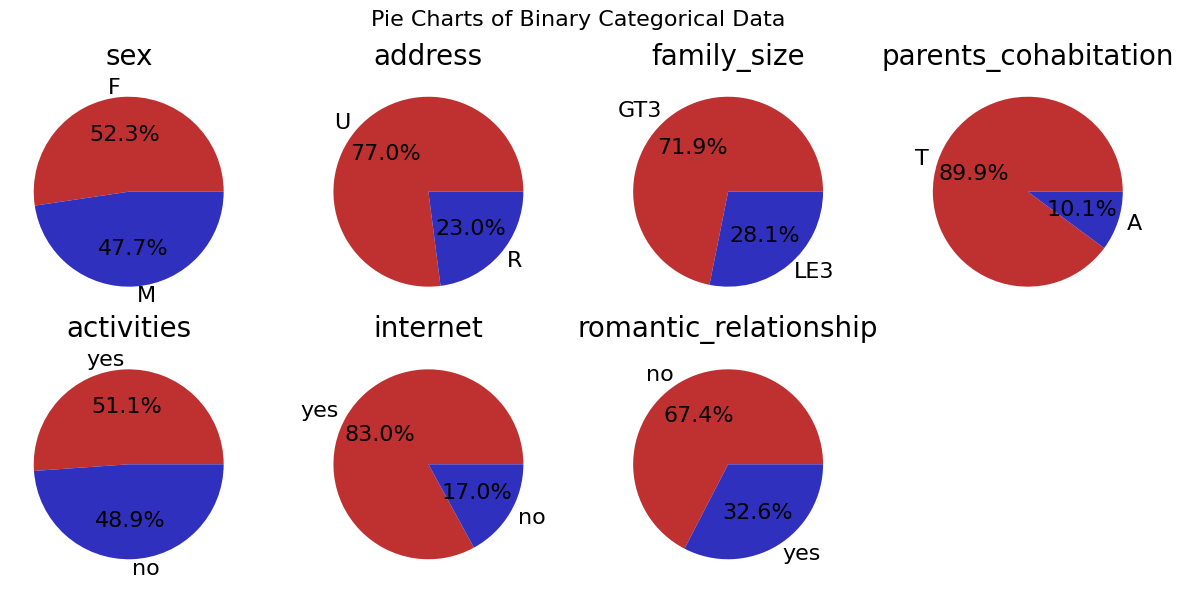

In [25]:
# Understand the binary column data
binary_columns = ["sex", "address", "family_size", "parents_cohabitation", "activities", "internet", "romantic_relationship"]

# Create a figure and a grid of subplots
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.flatten()

# Plot each pie chart in a subplot
for i, var in enumerate(binary_columns):
    ax = axes[i]
    df_clean[var].value_counts().plot(kind="pie", autopct="%1.1f%%", colors=["#BF3030", "#3030BF"], ax=ax, textprops={"fontsize": 16})
    ax.set_title(var, fontsize="20")
    ax.set_ylabel("")

# Remove the last empty plot
if len(binary_columns) % 2 != 0:
    axes[-1].axis("off")

# Show plot
plt.tight_layout()
plt.suptitle("Pie Charts of Binary Categorical Data", fontsize=16)
plt.subplots_adjust(top=0.875)
plt.show()

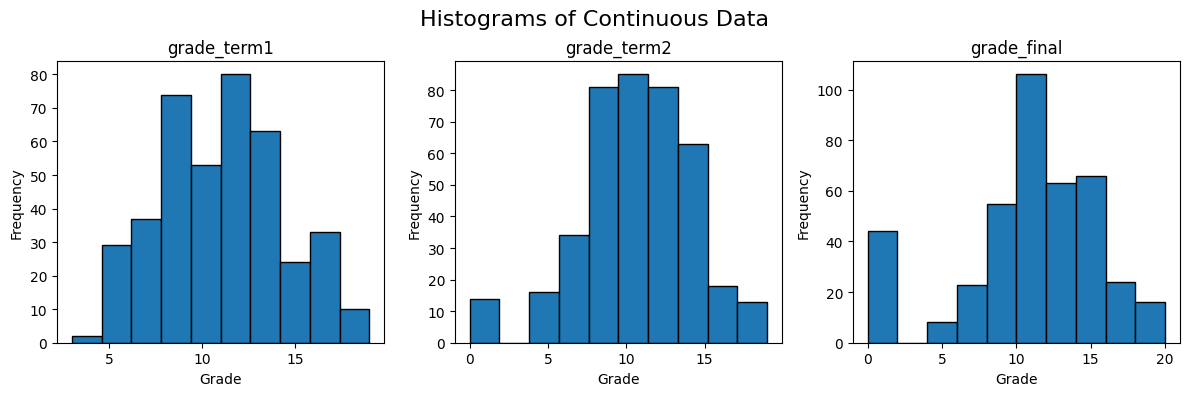

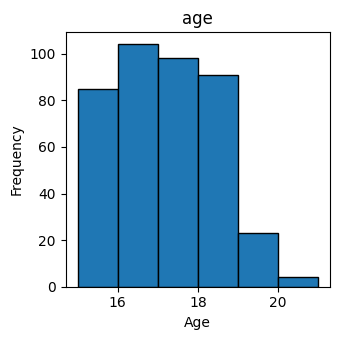

In [26]:
# Produce histograms for the continuous data
# Define the histogram plotting function
def plot(df_plot, x_label, y_label):
    for i, col in enumerate(df_plot.columns):
        numeric_values = pd.to_numeric(df_plot[col], errors="coerce")
        axes[i].hist(numeric_values, bins=10, edgecolor="black")
        axes[i].set_title(col)
        axes[i].set_xlabel(x_label)
        axes[i].set_ylabel(y_label)

# Produce historgrams for the students' grades
df_grades = df_clean[grade_cols]
# Define the subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 4)) 
# Plot the histograms
plot(df_grades, "Grade", "Frequency")
plt.tight_layout()
plt.suptitle("Histograms of Continuous Data", fontsize=16)
plt.subplots_adjust(top=0.85)
plt.show()

# Produce a histogram for age
fig, axes = plt.subplots(figsize=(3.5, 3.5)) 
numeric_values_age = pd.to_numeric(df_clean["age"], errors="coerce")
# Define the number of bins (based off the spread analysis)
axes.hist(numeric_values_age, bins=6, edgecolor="black")
axes.set_title("age")
axes.set_xlabel("Age")
axes.set_ylabel("Frequency")
plt.tight_layout()
plt.show()

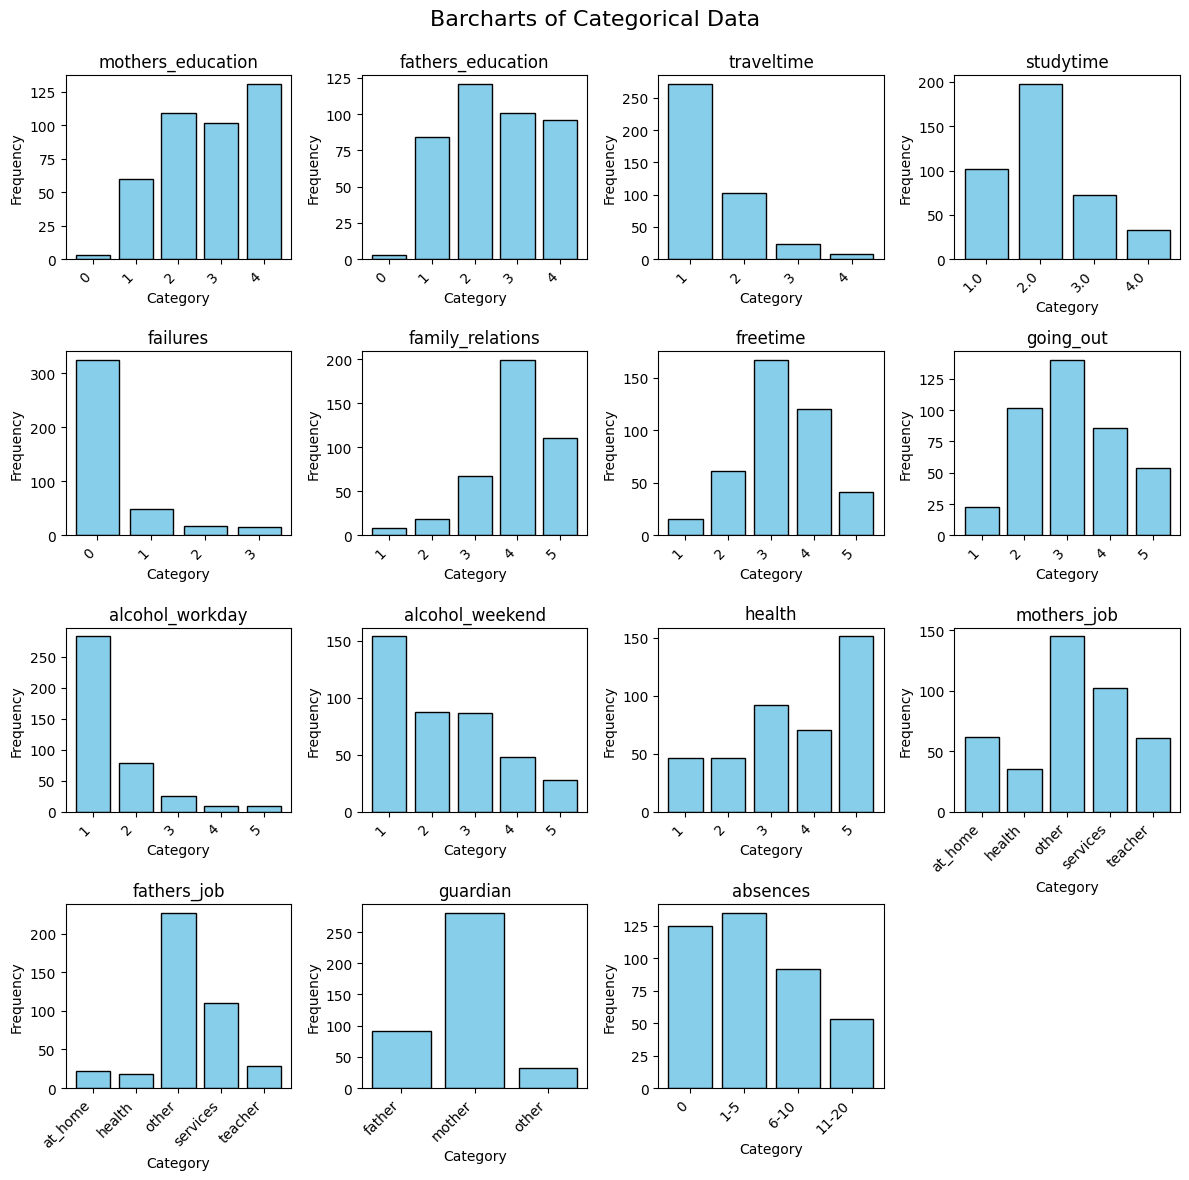

In [27]:
# Produce bar charts for the categorical data
# Define the bar chart plotting function
def plot_categorical(df_plot, x_label, y_label):
    for i, col in enumerate(df_plot.columns):
        # Ensure to order the integer values
        value_counts = df_plot[col].value_counts().sort_index()
        x_ticks = range(len(value_counts))
        axes[i].bar(x_ticks, value_counts.values, color="skyblue", edgecolor="black")
        axes[i].set_title(col)
        axes[i].set_xlabel(x_label)
        axes[i].set_ylabel(y_label)
        # Ensure the labels are displayed and in the correct position
        axes[i].set_xticks(x_ticks)
        axes[i].set_xticklabels(value_counts.index, rotation=45, ha='right')

# Produce the bar charts for all the categorical data
categorical_cols = ["mothers_education", "fathers_education", "traveltime", "studytime", "failures",
                                 "family_relations", "freetime", "going_out", "alcohol_workday", 
                                 "alcohol_weekend", "health", "mothers_job", "fathers_job", "guardian", "absences"]
df_categorical = df_clean[categorical_cols]
# Define the subplots
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
axes = axes.flatten()

# Plot the bar charts
plot_categorical(df_categorical, "Category", "Frequency")
# Remove the last empty plot
if len(categorical_cols) < len(axes):
    for ax in axes[len(categorical_cols):]:
        ax.axis('off')

plt.tight_layout()
plt.suptitle("Barcharts of Categorical Data", fontsize=16)
plt.subplots_adjust(top=0.925)
plt.show()

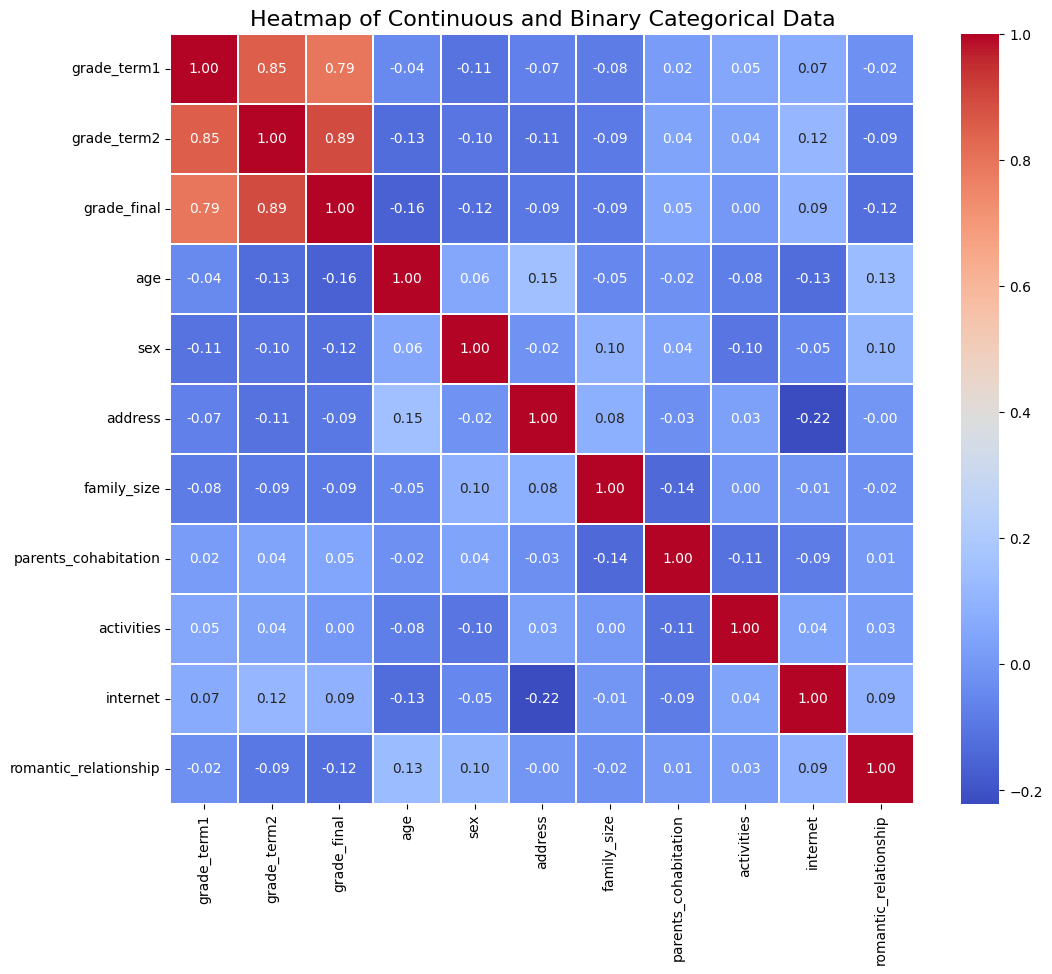

In [28]:
# Produce a heatmaps
# Heatmap for the binary categorical and continuous data
df_heatmap = df[["grade_term1", "grade_term2", "grade_final", "age", "sex", "address", "family_size", "parents_cohabitation", "activities", "internet", "romantic_relationship"]]

# Define the figure size 
plt.figure(figsize=(12, 10))
# Define and plot the heatmap
correlation_matrix = df_heatmap.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.1)
plt.title("Heatmap of Continuous and Binary Categorical Data", fontsize=16)
plt.show()

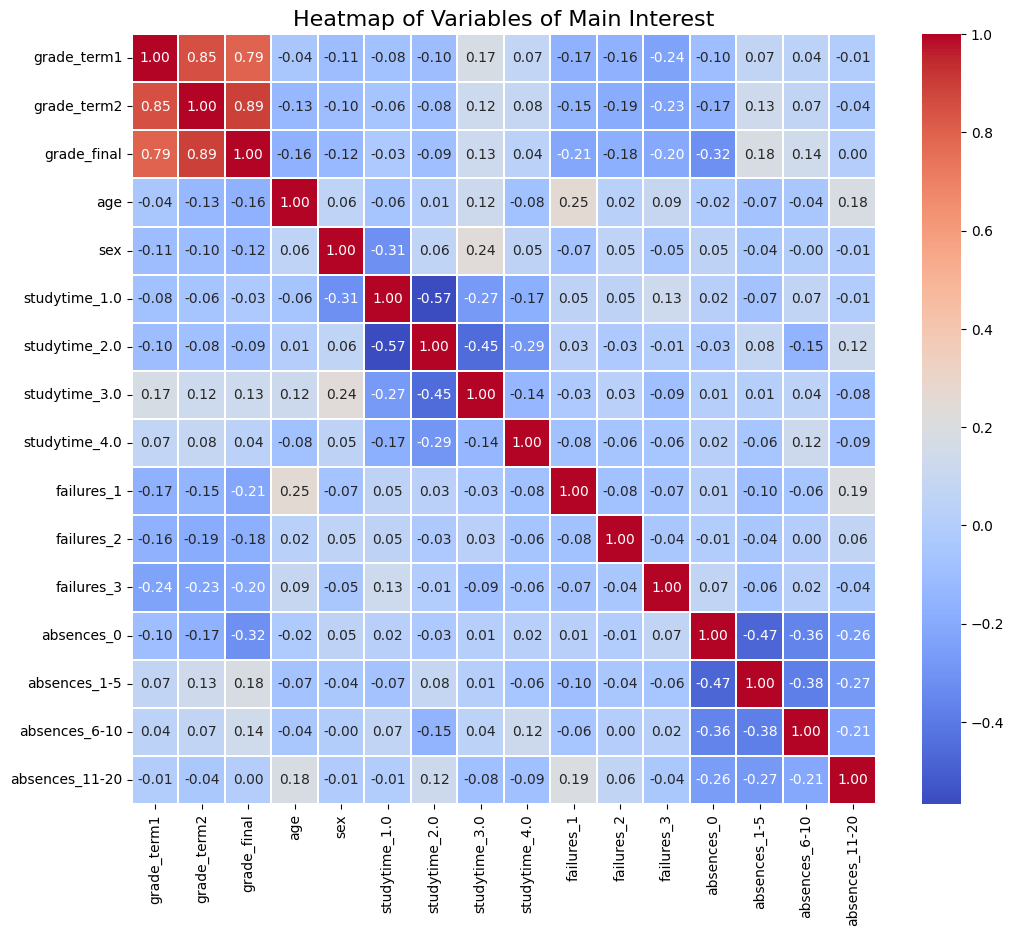

In [29]:
# Heatmap for notable categorical, binary categorical and continuous data
df_heatmap = df[["grade_term1", "grade_term2", "grade_final", "age", "sex", "studytime_1.0", "studytime_2.0", "studytime_3.0", 
                  "studytime_4.0", "failures_1", "failures_2", "failures_3", "absences_0", "absences_1-5", "absences_6-10", "absences_11-20"]]

# Define the figure size 
plt.figure(figsize=(12, 10))
# Define and plot the heatmap
correlation_matrix = df_heatmap.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.1)
plt.title("Heatmap of Variables of Main Interest", fontsize=16)
plt.show()

In [30]:
# Create a pairplot using the grade data and the categorical variables we are interested in
# Pairplot function including the grade data
def generate_pairplot(df_pairplot, hue_col, title):
    sns.pairplot(df_pairplot, vars=["grade_term1", "grade_term2", "grade_final"], hue=hue_col, diag_kind="kde", height=2, aspect=1)
    plt.suptitle(title, fontsize=16, y=1.04)
    plt.show()

# Set the hue to the main catgeorical variable we are interested in
# Generate the pairplots
generate_pairplot(df, "sex", "Scatterplot Matrix with Sex Data")
generate_pairplot(df_clean, "studytime", "Scatterplot Matrix with Study Time Data")
generate_pairplot(df_clean, "failures", "Scatterplot Matrix with Failure Data")
generate_pairplot(df_clean, "absences", "Scatterplot Matrix with Absences Data")


Brief observations for question 2:

See the self-explanatory binary categorical data – there appears to be roughly an equal number of male and female students, with slightly more female students, and not all students have access to the internet at home. 

See the histograms of continuous data – many students have a grade of 0 for the term 2 test and the final test, this may be the case or these students may not have sat the test. Most students achieve scores close and around 10/20. The majority of students are aged 15 to 19.
    
See the bar charts of categorical data – there is a normal distribution of free time and going out. Many students have 1-5 absences but a high proportion still have 0. Students tend to drink more on the weekends.

    
See the heatmap of continuous and binary categorical data – the grades in term 1, term 2 and the finals grade have a high correlation coefficient suggesting they are similar in form to one another. Those living in rural areas tend to have better slightly access to the internet.

See the heatmap of variables of main interest – failures and those with 0 absences may slightly indicate grades achieved. Those with fewer failures may be slightly younger which makes sense since they would not have sat most of the course. Absences and study time appear to be correlated respectively with themselves, which is trivially correct.

See the scatterplot matrices – sex does not indicate much regarding student performance. Those studying more, but not too much, perform slightly better. Those with fewer failures perform better and those with fewer absences perform ever slightly better.


### Machine Learning Models

#### Polynomial Regression with PCA (on Grade Term 1)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Polynomial Degree: 1
Best PCA Dimension: 9

Mean Squared Error (MSE): 0.03358790749214162
Mean Absolute Error (MAE): 0.14836430636869022
R2 Score: 0.06040659675689242


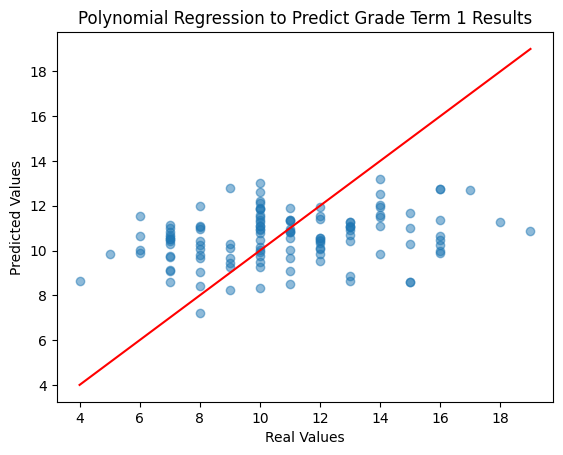

In [ ]:
# Takes a minute to train
# Make a copy of our df
df_poly = df.copy(deep=True)

# Define the x and y targets, including th egrades of term 1
x_poly = df_poly.drop(grade_cols, axis=1)
y_poly = df_poly["grade_term1"]
# Split 70% for training, 20% for testing and 10% for validation
x_train, x_test, y_train, y_test = train_test_split(x_poly, y_poly, test_size=0.3, random_state=4)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=1/3, random_state=4)

# Initialise the model
pipeline = make_pipeline(StandardScaler(), PolynomialFeatures(), PCA(), LinearRegression())
# Define the hyperparameter grid, with polynomial degrees 1 to 3 and dimensions 2 to 9
param_grid = {"polynomialfeatures__degree": range(1, 4),
              "pca__n_components": range(2, 10)}
# Initialise the grid search to find the best polynomial degree
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)
# Train the model
grid_search.fit(x_train, y_train)

# Predict on the test set
y_pred = grid_search.predict(x_test)
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the best hyperparameter values and the evaluation metrics
print("Best Polynomial Degree: " + str(grid_search.best_params_["polynomialfeatures__degree"]))
print("Best PCA Dimension: " + str(grid_search.best_params_["pca__n_components"]) + "\n")
print("Mean Squared Error (MSE): " + str(mse))
print("Mean Absolute Error (MAE): " + str(mae))
print("R2 Score: " + str(r2))

# Rescale the test values based on the max and min values, since we normalised before
y_test_rescaled = y_test * (19 - 3) + 3
y_pred_rescaled = y_pred * (19 - 3) + 3

# Plot the real values against the predicted values
plt.scatter(y_test_rescaled, y_pred_rescaled, alpha=0.5)
plt.title("Polynomial Regression to Predict Grade Term 1 Results")
plt.xlabel("Real Values")
plt.ylabel("Predicted Values")
plt.plot([min(y_test_rescaled), max(y_test_rescaled)], [min(y_test_rescaled), max(y_test_rescaled)], color="red")
plt.show()

#### Ridge Regression (on Grade Term 2)

Fitting 10 folds for each of 96 candidates, totalling 960 fits
Best Polynomial Degree: 1
Best PCA Dimension: 2
Best Ridge Alpha Value: 0.001

Mean Squared Error (MSE): 0.03724437224874358
Mean Absolute Error (MAE): 0.14487721297286468
R2 Score: 0.10130534184195894


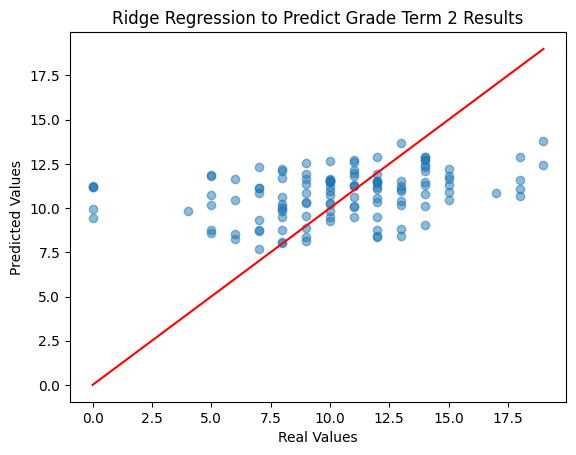

In [ ]:
# Takes 45 seconds to train
# Make a copy of our df
df_ridge = df.copy(deep=True)

# Define the x and y targets, including the grades of term 2
x_ridge = df_ridge.drop(grade_cols, axis=1)
y_ridge = df_ridge["grade_term2"]
# Split 70% for training, 20% for testing and 10% for validation
x_train, x_test, y_train, y_test = train_test_split(x_ridge, y_ridge, test_size=0.3, random_state=44)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=1/3, random_state=44)

# Initialise the model
pipeline = make_pipeline(StandardScaler(), PolynomialFeatures(), PCA(), Ridge())
# Define the hyperparameter grid, with polynomial degrees 1 to 2, dimensions 2 to 9 and alpha between 10^-3 and 10^1
param_grid = {"polynomialfeatures__degree": range(1, 3),
              "pca__n_components": range(2, 10),
              "ridge__alpha": [0.001, 0.01, 0.1, 1, 10, 50]}
# Initialise the grid search to find the best polynomial degree
grid_search = GridSearchCV(pipeline, param_grid, cv=10, scoring='neg_mean_squared_error', verbose=1)
# Train the model
grid_search.fit(x_train, y_train)

# Predict on the test set
y_pred = grid_search.predict(x_test)
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the best hyperparameter values and the evaluation metrics
print("Best Polynomial Degree: " + str(grid_search.best_params_["polynomialfeatures__degree"]))
print("Best PCA Dimension: " + str(grid_search.best_params_["pca__n_components"]))
print("Best Ridge Alpha Value: " + str(grid_search.best_params_["ridge__alpha"]) + "\n")
print("Mean Squared Error (MSE): " + str(mse))
print("Mean Absolute Error (MAE): " + str(mae))
print("R2 Score: " + str(r2))

# Rescale the test values based on the max and min values, since we normalised before
y_test_rescaled = y_test * (19 - 0) + 0
y_pred_rescaled = y_pred * (19 - 0) + 0

# Plot the real values against the predicted values
plt.scatter(y_test_rescaled, y_pred_rescaled, alpha=0.5)
plt.title("Ridge Regression to Predict Grade Term 2 Results")
plt.xlabel("Real Values")
plt.ylabel("Predicted Values")
plt.plot([min(y_test_rescaled), max(y_test_rescaled)], [min(y_test_rescaled), max(y_test_rescaled)], color="red")
plt.show()

#### Elastic Net Regression (on Grade Final)

Fitting 5 folds for each of 400 candidates, totalling 2000 fits
Best Polynomial Degree: 1
Best PCA Dimension: 3
Best Elastic Net Alpha Value: 0.001
Best Elastic Net L1 Ratio: 0.01

Mean Squared Error (MSE): 0.04395201441914817
Mean Absolute Error (MAE): 0.16006296983270182
R2 Score: 0.04851078354604699


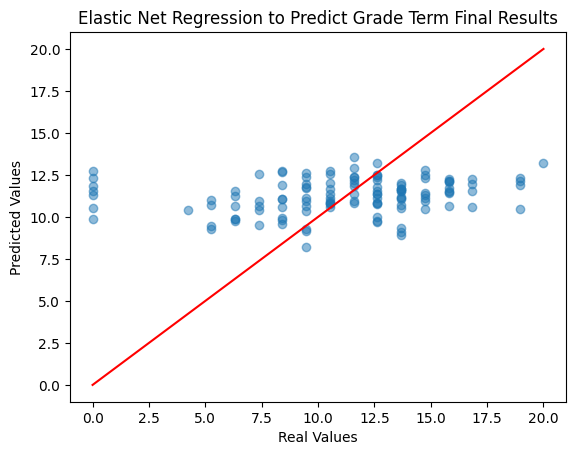

In [ ]:
# Takes 1 minute 30 seconds to train
# Make a copy of our df
df_elastic = df.copy(deep=True)

# Define the x and y targets, including the grades of term final
x_elastic = df_elastic.drop(grade_cols, axis=1)
y_elastic = df_elastic["grade_term2"]
# Split 70% for training, 20% for testing and 10% for validation
x_train, x_test, y_train, y_test = train_test_split(x_elastic, y_elastic, test_size=0.3, random_state=4444)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=1/3, random_state=4444)

# Initialise the model
pipeline = make_pipeline(StandardScaler(), PolynomialFeatures(), PCA(), ElasticNet())
# Define the hyperparameter grid, with polynomial degrees 1 to 2, dimensions 2 to 9 and alpha between 10^-3 and 10^1
param_grid = {"polynomialfeatures__degree": range(1, 3),
              "pca__n_components": range(2, 10),
              "elasticnet__alpha": [0.001, 0.01, 0.1, 1, 10],
              "elasticnet__l1_ratio": [0.01, 0.2, 0.5, 0.8, 0.99]}
# Initialise the grid search to find the best polynomial degree
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)
# Train the model
grid_search.fit(x_train, y_train)

# Predict on the test set
y_pred = grid_search.predict(x_test)
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the best hyperparameter values and the evaluation metrics
print("Best Polynomial Degree: " + str(grid_search.best_params_["polynomialfeatures__degree"]))
print("Best PCA Dimension: " + str(grid_search.best_params_["pca__n_components"]))
print("Best Elastic Net Alpha Value: " + str(grid_search.best_params_["elasticnet__alpha"]))
print("Best Elastic Net L1 Ratio: " + str(grid_search.best_params_["elasticnet__l1_ratio"]) + "\n")
print("Mean Squared Error (MSE): " + str(mse))
print("Mean Absolute Error (MAE): " + str(mae))
print("R2 Score: " + str(r2))

# Rescale the test values based on the max and min values, since we normalised before
y_test_rescaled = y_test * (20 - 0) + 0
y_pred_rescaled = y_pred * (20 - 0) + 0

# Plot the real values against the predicted values
plt.scatter(y_test_rescaled, y_pred_rescaled, alpha=0.5)
plt.title("Elastic Net Regression to Predict Grade Term Final Results")
plt.xlabel("Real Values")
plt.ylabel("Predicted Values")
plt.plot([min(y_test_rescaled), max(y_test_rescaled)], [min(y_test_rescaled), max(y_test_rescaled)], color="red")
plt.show()

### Written Discussion

a)	Before data preparation, the dataset was inspected through opening the csv file and using various Pandas functions to gather more detail about variables, such as the number of categories that were intended to be an option. This analysis enabled data cleaning to take place, to remove unnecessary or incorrect data, remove data that could not be processed further and remove outliers that would potentially hinder future predictions by an ML model. 

Firstly, rows with nan values were removed due to the uncertainty of how every data point relates to another for each student. It was ensured that rows contained only valid categorical entries, as other data would be incorrect. For example, a 7 was found for “sex” when only “M” or “F” should be accepted. Following this cleaning, outlier rows were removed for “age” and “absences”, since these can affect other data point values resulting in a model producing less accurate predictions. These outliers were identified as values above Q3 + 1.5(IQR) or below Q1 - 1.5(IQR). Since “absences” was quite a diverse continuous variable, with many students with 0 absences and many others with larger values, this was binned into 4 groups (“0”, “1-5”, “6-10” and “11-20”) to assist the ML model in judging how absences correlates with student performance in a simpler way.

The data was then normalised to create a scaled representation ready for machine learning. This involved converting binary categorical data into a “0, 1” representation. Categorical variables were split into many binary vectors with one-hot encoding, enabling the ML algorithms to understand each separate category’s relationships well. Finally, the remaining continuous columns were scaled between 0 and 1, resulting in a complete table with values only between 0 and 1 ready for processing.

All data columns were included for the ML models since they all could affect student performance to some degree. This allows the models to use as much data as possible to find further relationships and aptly predict student performance.


b)	The models trained include:

•	Model 1: Polynomial regression to predict grade_term1

•	Model 2: Ridge regression to predict grade_term2

•	Model 3: Elastic net regression to predict grade_final

Hyperparameter tuning, including PCA, was included to provide improved predictions. Predictions, however, were limited by hardware constraints. The below are results of the models’ performances:

•	Model 1: Mean Squared Error (MSE): 0.03359, Mean Absolute Error (MAE): 0.1484, R2 Score: 0.06041

•	Model 2: Mean Squared Error (MSE): 0.03724, Mean Absolute Error (MAE): 0.1449, R2 Score: 0.1013

•	Mean Squared Error (MSE): 0.04395, Mean Absolute Error (MAE): 0.1601, R2 Score: 0.04851

All of these models produce very low MSE and MAE scores, suggesting that predictions are very close on average to real student grade values with low margins of error. However, all these models also produce very low R^2 scores. This suggests that the data points predicted through the validation set do not accurately fit with the real shape of data – only a small portion of this has been understood by the model.

This may be due to numerous reasons. Firstly, the model does not accurately detect the patterns between variables as a means to predict student performance. Hence, more advanced ML algorithms could be implemented or the model should be trained with more parameters on a better machine. On the other hand, overfitting may be occurring as the model works well on the training dataset but does not generalise well for the validation set, and so the model and its parameters should be reassessed. Another reason for the poor models is due to the processed dataset used leading to the inclusion of too many variables unrelated to student performance. If this is the case, these should be removed and the model should be retrained. However, going back further, a more likely theory is that the variables that make up the original dataset may simply not be suitable in predicting performance.


c)	Linking back to previously, the original dataset may not be suitable in predicting student performance. This is demonstrated through the extremely low R^2 values, which indicate poor model performance. 

The initial issue with the dataset was necessity of data cleaning due to incorrect datapoints being present. Through exploratory data analysis, when assessing the grade data, grade_term2 and grade_final have a large proportion of students with a grade of 0. It cannot be concluded the proportion that actually achieved these grades or whether any of those students did not that the test – hence the data of our dependent variable was collected poorly and this affects any ML models trained.

When considering general features, there are far too many variables. A strong logical argument can be made for only a handful of these in being directly linked to student progress. This includes, study time, failures and absences, however only weaker arguments can be made for variables such as mothers job and address. A strong dataset choice would include many strong links mental or physical features that link to student performance, such as hours studying in the library. When assessing the heatmap, many variables had little to no links with one another. Additionally, many of the variables were on a categorical scale of 1-5 without much detail. Further detail through continuous variables would be preferrable, such as the exact hours of study time – enabling ML models to better understand the different variables and their links.